### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
### Convert types
df = convert_types(df, cols_num, col_target=col_target)

from utilities import create_dt_feats
df = create_dt_feats(df, 'txn_dt')
df = create_dt_feats(df, 'building_complete_dt')
df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
cols_num = cols_num + ['day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt']
cols_cat = cols_cat + ['dow_txn_dt', 'dow_building_complete_dt',
                       'month_txn_dt', 'month_building_complete_dt',
                       'quarter_txn_dt', 'quarter_building_complete_dt',
                       'year_txn_dt', 'year_building_complete_dt']
cols_feats = cols_num + cols_cat + cols_bin

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [11]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

#### Round 1

In [12]:
%%time
params_gsearch1 = {'num_leaves': [255,],           # may reduce in dim-reduction exp
                   'feature_fraction': [0.5,],
                   'min_data_in_leaf': [5,],
                   'lambda_l1': [0.01,],
                   'lambda_l2': [0,],
                   }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    if i_fold > 0: continue

    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch1[key] for key in params_gsearch1]):
        params = params_fix.copy()
        params.update( dict(zip(params_gsearch1.keys(), values)) )
        print('params:', params)

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        
        y_pred_final = target_inverse_transform(df_val, y_pred)
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0087787
[4000]	valid_0's mape: 0.00866901
[6000]	valid_0's mape: 0.0086427
[8000]	valid_0's mape: 0.00863421
[10000]	valid_0's mape: 0.00863105
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00863105
5478.862222967167
CPU times: user 52min 31s, sys: 52.3 s, total: 53min 24s
Wall time: 4min 45s


In [13]:
display(gsearch_results1)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0)),
  5478.862222967167,
  [5478.862222967167]]]

### Conclusion

- Round 1 best params (random seed = 123):
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5)),  

Best scores: 5501.863278855861  
[5527.864888142274, 5498.864225711784, 5478.860722713526]

- Round 2 best params (random seed = 123):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0)  
  
Best scores: *5515.529915334645*  
[5532.864763855017, 5514.864357360793, 5498.860624788125]

- Round 2 best params (random seed = 246):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0.1)  
   
Best scores: *5524.863045737181*  
[5528.862755759428, 5530.862894274216, 5514.863487177898]

### Other info

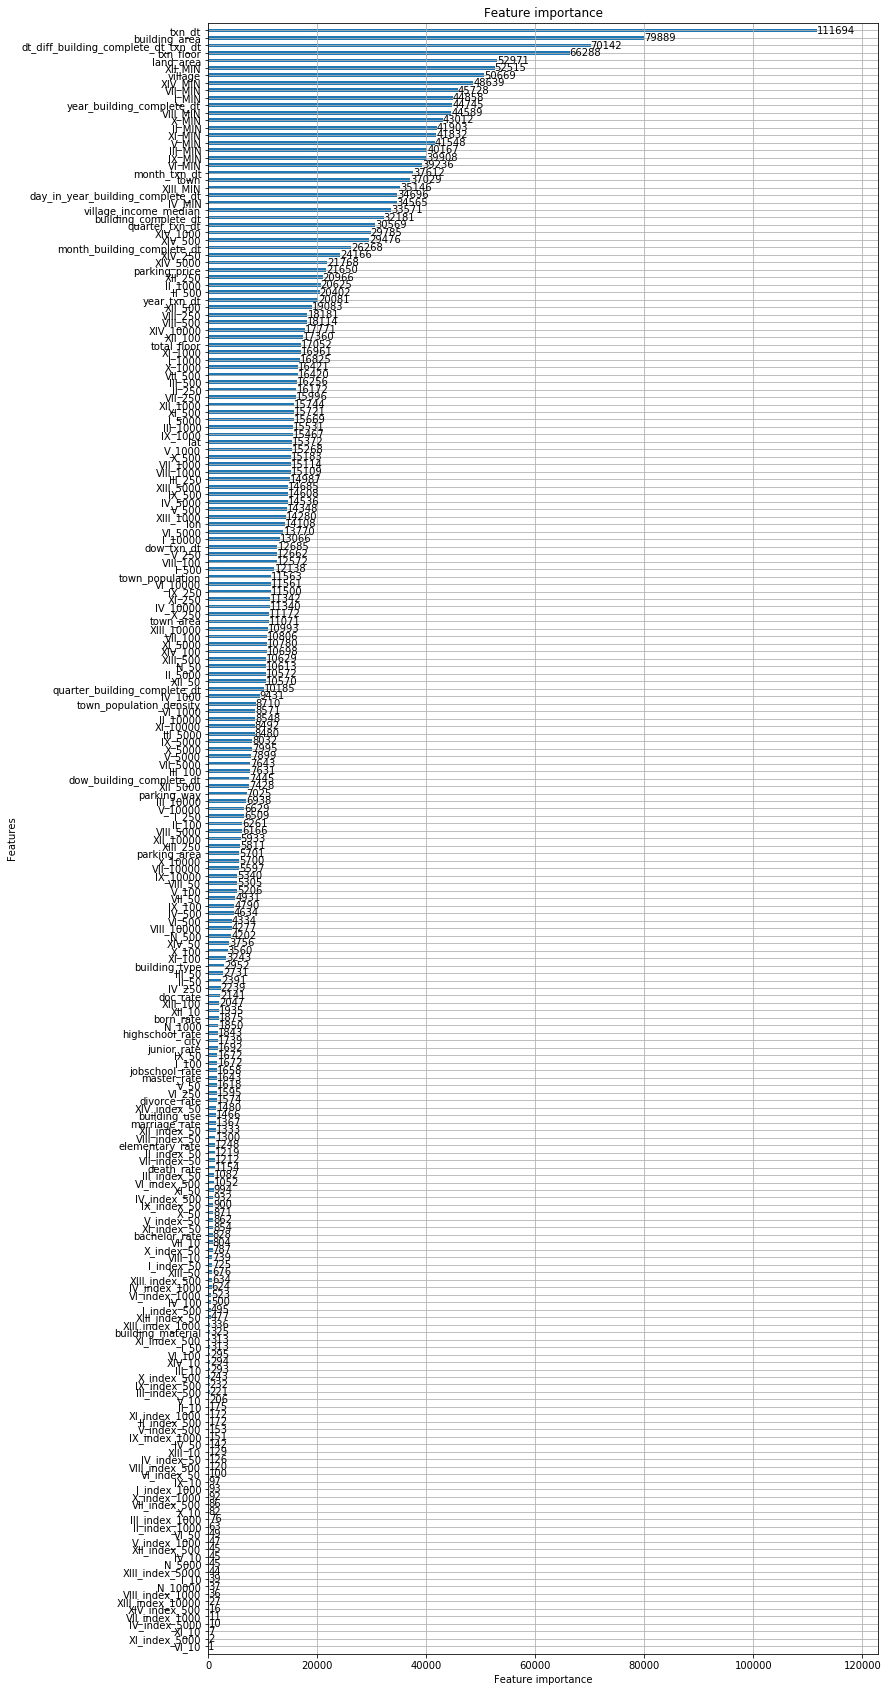

In [14]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

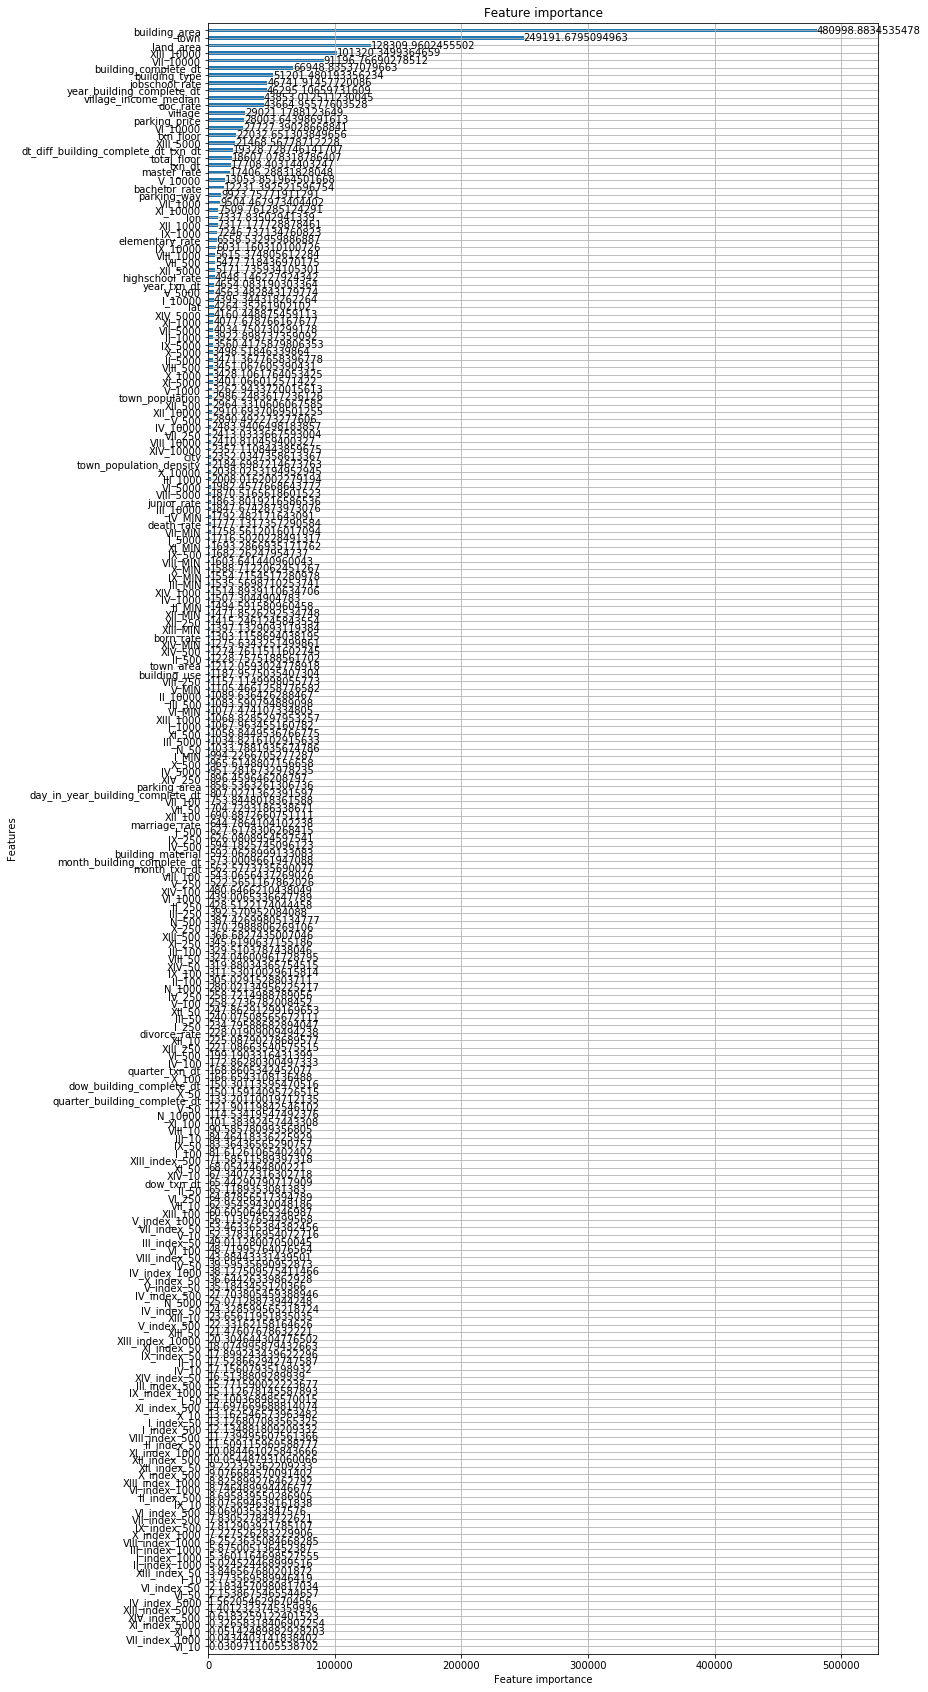

In [15]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()